# Demonstrations for lecture 16

This notebook contains code to demonstrate concepts in Lecture 16 - Deviations from normality. The lecture slides are numbered, and sections of this notebook will use this numbering to refer directly to particular slides. I recommend working through the code and lecture slides simultaneously.

In [30]:
## Import packages

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats

# Set size of font for matplotplib
plt.rc('font', size=15) 

# Remember we do not expect you to be proficient in the following packages.
import seaborn as sns
import bokeh as bk
from bokeh.palettes import Category20b
from bokeh.palettes import Magma
from bokeh.palettes import Viridis
from bokeh.palettes import gray
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import Span
from bokeh.models import Label


output_notebook()

print(bk.__version__)

Loading BokehJS ...

1.3.4


-------
## 1. Are my data normal? (slide 9)
------

Let's recall how to plot a normal distribution.

In [2]:
# We'll pick a standard range for x values.
x_axis = np.arange(-3,3,0.01)

# Examine different normal distributions by changing mu and sigma
mu_values = [-1.3, -0.8, 0, 0.5, 1]
sigma_values = [0.6, 0.5, 0.4, 0.7, 1.2]

# Preparing to plot normal distributions (using Bokeh)
p = figure(plot_width=800, plot_height=500)
p.title.text = 'Click on legend entries to hide the corresponding lines'

# Use for loop to plot each of the normal distributions
for mu, sigma, color in zip(mu_values, sigma_values, Category20b[5]):
    norm_data = stats.norm.pdf(x_axis, loc = mu, scale = sigma)
    p.line(x_axis, norm_data, line_width=2, color= color, alpha=0.8, legend = f'mu={mu}, sigma={sigma}')

# Add annotations
p.legend.location = "top_right"
p.legend.click_policy="hide"
p.xaxis.axis_label = 'X'
p.yaxis.axis_label = 'Probability density'

show(p)

### Histograms that do not look normal but are... (slide 12)

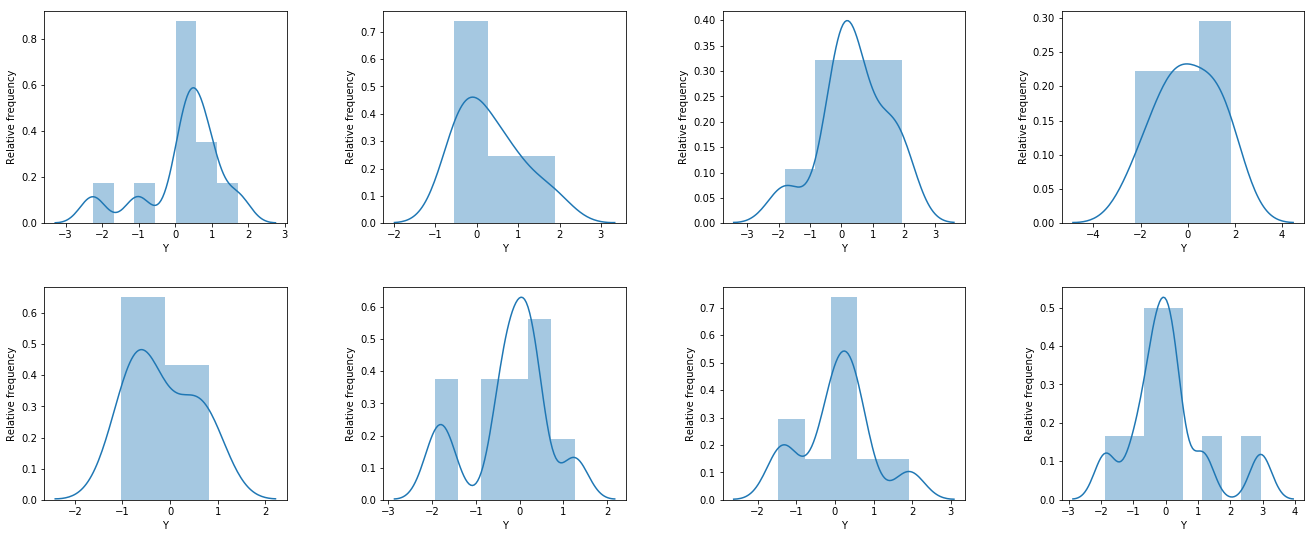

In [3]:
## Here we'll draw random samples with small n from a normal distribution with mean mu and standard deviation sigma.
## Do the resulting histograms suggest these are normally distributed data?

# number in sample
n = 10

# number of samples
n_samples = 8

# Define mu and sigma for the normal distribution
mu = 0
sigma = 1

# Draw histograms with matplotlib for subplots and seaborn for histograms
plt.figure(figsize=(20,9))
for i in np.arange(n_samples):
    
    normal_sample = np.random.normal(mu, sigma, n)
    plt.subplot(2, 4, i+1)
    sns.distplot(normal_sample)
    plt.xlabel('Y')
    plt.ylabel('Relative frequency')

# Adjust spacing between the subplots
plt.subplots_adjust(bottom=None, right=1, top=None, wspace=0.4, hspace = 0.3)

## Quantile plots (slide 13)
_____

### Cumulative density function of a normal distribution (slide 14)

Definition: the cumulative density function (CDF) shows the fraction of observations less than or equal to a given measurement.

In [28]:
## We will plot both the pdf and the cdf of a normal distribution. We will use bokeh to link the two
# together so the relationship is more clear. Feel free to change the mu and sigma values (<3).

mu = 0
sigma = 1



## Code to make the data and plot (bokeh)

# Colors
line_color = "#0b3e61"
area_color = "#1885d1"
pdf_color = "#556270"
cdf_color = "#94a0a8"

# Data
x = x_axis
x2 = x_axis
y = stats.norm.pdf(x, loc = mu, scale = sigma)
z_line = np.zeros(np.size(x_axis))+3
y1 = np.zeros(np.size(x_axis))
y_keep = stats.norm.pdf(x, loc = mu, scale = sigma)
y_cdf = stats.norm.cdf(x, loc = mu, scale = sigma)
y_circle = stats.norm.cdf(z, loc = mu, scale = sigma)

source = ColumnDataSource(data=dict(x=x, y=y,
                                    z_line=z_line, y1 = y1, y_keep = y_keep,
                                    y_cdf = y_cdf, y_circle = y_circle))

# Start figure
plot = figure(y_range=(0, np.max(y_keep)+0.2), plot_width=600, plot_height=400)
plot_2 = figure(y_range=(0, 1.2), plot_width=600, plot_height=400)

plot_2.line(x, y_cdf, line_width = 5, color = cdf_color)

# Plot initial line
plot.line(x, y, line_width=3, line_alpha=1, color = pdf_color)

# Plot slider line
plot.line('z_line','y_keep', source = source, color = line_color)
plot_2.line('z_line','y_cdf', source = source, color = line_color)


plot_2.circle('z_line','y_circle', source=source, size=20, color=area_color, alpha=0.5)

# Plot fill under curve
plot.varea('x', y1 = 'y1', y2 ='y',
         fill_alpha = 0.80,
         legend = 'area (P[X < slider])',
         color = area_color, source = source)

# Define sliders
line_slider = Slider(start=-3, end=3, value=3, step=0.01, title="slider")

# Javascript lets us make interactive sliders
callback = CustomJS(args=dict(source=source, line_slider=line_slider, m = mu, s = sigma),
                    code="""

    function normalcdf(mean, sigma, to) {
    var z = (to-mean)/Math.sqrt(2*sigma*sigma);
    var t = 1/(1+0.3275911*Math.abs(z));
    var a1 =  0.254829592;
    var a2 = -0.284496736;
    var a3 =  1.421413741;
    var a4 = -1.453152027;
    var a5 =  1.061405429;
    var erf = 1-(((((a5*t + a4)*t) + a3)*t + a2)*t + a1)*t*Math.exp(-z*z);
    var sign = 1;
    if(z < 0)
    {
        sign = -1;
    }
    return (1/2)*(1+sign*erf);}
    
    const data = source.data;
    console.log(m)

    const x = data['x']
    const y = data['y']
    const z_line = data['z_line']
    const y_keep = data['y_keep']
    const y_circle = data['y_circle']
    const l = line_slider.value
    console.log(l)

    for (var i = 0; i < x.length; i++) {
        
        z_line[i] = l
        
        if (l<x[i]){
            y[i] = 0
        }
        if (l>x[i]){
            y[i] = y_keep[i]
        }
        
        y_circle[i] = normalcdf(m,s,l)
    }

    source.change.emit();
""")

# Defining what happens when a slider value changes. In this case, the callback function evaluates.
line_slider.js_on_change('value', callback)

# Final plot labels and things
plot.xaxis.axis_label = 'X'
plot.yaxis.axis_label = 'Probability Density'
plot_2.xaxis.axis_label = "X"
plot_2.yaxis.axis_label = 'Cumulative probability Density P(x<X)'
layout = row(
    column(plot, plot_2),
    column(line_slider),
)


show(layout)

## Normal quantile plots (slide 16)

Here we will break down the steps of generating a normal quantile plot. Let's call our data `data`. Feel free to change the values in `data` to observe the effect.

In [34]:
# First we have some toy data. Add or remove values as well.
# In general our data can be any size but for this particular code please keep the length < 11
data = [1,20,3,4,5,6,7,8,13]
n = len(data)


# Next we'll compute the proportions for n+1 quantiles (so that we'll get n lines in the end)
quantiles_needed = [(i+1)/(n+1) for i in np.arange(n+1)]
print(f"Quantiles: {quantiles_needed}")


# In general we'll compare with the standard normal distribution, but you can change mu and sigma if you like.
mu = 0
sigma = 1
norm_pdf = stats.norm.pdf(x_axis, loc = mu, scale = sigma)

# Generate a normally distributed example set of data. Then compute the quantiles on these data according to 
# the quantiles defined above.
norm_example_data = np.random.normal(0, 1, 10000)
norm_quantiles = np.quantile(norm_example_data, quantiles_needed)
print(f"Normal values at each quantile:{norm_quantiles}")

# Plot the quantiles of the normal distribution. The vertical lines mark the values we'll need for the next step.
p = figure(plot_width=800, plot_height=500, x_range = (-3,3), title = "Quantiles in the normal distribution")
p.title.text = 'Click on legend entries to hide the corresponding lines'


# Plotting the normal distribution
p.line(x_axis, norm_pdf, line_width=2,alpha=0.8, legend = f'mu={mu}, sigma={sigma}', color = pdf_color)

# Plot all quantiles on top of the normal distribution
q_last = -5
for q, color, qn in zip(norm_quantiles, Viridis[n+1], quantiles_needed):

    p.line(q*np.ones(2), 0.4*np.arange(2), color = color)
    
    x_range = ((x_axis < q) & (x_axis > q_last))
    p.varea(x_axis[x_range],np.zeros((sum(x_range))),
         norm_pdf[x_range],
         fill_alpha = 0.20,
         legend = f'{qn:.2f} quantile',
         color = color)
    
    q_last = q
    


# Add attributes
p.legend.location = "top_right"
p.legend.click_policy="hide"
p.xaxis.axis_label = 'X'
p.yaxis.axis_label = 'Probability density Pr[x = X]'



## Next plot the cumulative density function and highlight the quantiles on this plot
# Generate the cdf
y_cdf = stats.norm.cdf(x_axis, loc = mu, scale = sigma)

# Plot!
p1 = figure(plot_width=800, plot_height=500, x_range = (-3,3), title = "Cumulative density function")
p1.line(x_axis, y_cdf, color = cdf_color)
p1.circle(norm_quantiles[0:-1], stats.norm.cdf(norm_quantiles[0:-1]), fill_color = Viridis[n+1][0:-1], radius = 0.1)
p1.xaxis.axis_label = 'X'
p1.yaxis.axis_label = 'Cumulative density Pr[x < X]'

# Adding text labels -- remove if they get too busy.
for i in np.arange(n):
    mytext = Label(x=norm_quantiles[i], y=stats.norm.cdf(norm_quantiles[i])-0.1, text=f'{norm_quantiles[i]:.2f}')
    p1.add_layout(mytext)

    
## Finally the last plot will show our made-from-scratch quantile plot. We'll use the values of the vertical lines
# or the points along the cdf as x values and our SORTED data points as y values.

# Sort data (increasing)
data.sort()

# Prepare figure
p2 = figure(plot_width=800, plot_height=500, x_range = (-3,3), title = "Quantile-Quantile plot")

# Plot lines extending to each data point
for q, color_q, d, color_d in zip(norm_quantiles, Viridis[n+1], data, gray(n+1)):
    
    p2.line(q*np.ones(2), d*np.arange(2), color = color_q, line_width = 1.8)
    p2.line([-3,q], d*np.ones(2), color = color_d, line_width=1.8)
    mytext = Label(x=q+0.1, y=d-1, text=f'({q:.2f},{d:.2f})')
    p2.add_layout(mytext)
    
# Plot circles at each point
p2.circle(norm_quantiles[0:-1], data, radius = 0.08, fill_color = "white", line_color = "black")
p2.xaxis.axis_label = "X (from the standard normal)"
p2.yaxis.axis_label = "data values"

layout = column(p,p1,p2)
show(layout)

Quantiles: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Normal values at each quantile:[-1.27892693 -0.82883478 -0.52443389 -0.24979557  0.01424108  0.26498586
  0.53270295  0.84425053  1.28123515  3.84839473]


### Plotting quantile plots with python functions (slide 17)

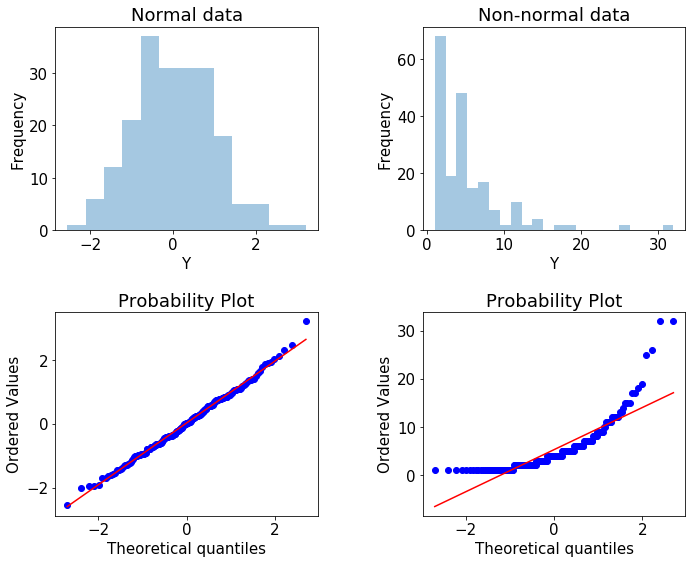

In [48]:
# Generate a normally distributed sample and a non-normally distributed sample

# Change mu and sigma
mu = 0
sigma = 1

n_points = 200

# Generate normal data
qq_data_norm = np.random.normal(mu, sigma, n_points)

# Generate not normal data 
qq_data_notnorm = np.random.geometric(p=0.2, size=n_points)

plt.figure(figsize=(10,9))
plt.subplot(2, 2, 1)
sns.distplot(qq_data_norm, kde = False)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Normal data')

plt.subplot(2,2,3)
stats.probplot(qq_data_norm, sparams = (mu, sigma), dist = "norm", plot = plt)

plt.subplot(2,2,2)
sns.distplot(qq_data_notnorm, kde = False)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Non-normal data')

plt.subplot(2,2,4)
stats.probplot(qq_data_notnorm, sparams = (mu, sigma), dist = "norm", plot = plt)


# Adjust spacing between the subplots
plt.subplots_adjust(bottom=None, right=1, top=None, wspace=0.4, hspace = 0.4)

### Shapiro-Wilk test (slide 19)
______

Protein-protein interaction networks provide information on robustness, function, and cooperation of proteins and enzymes. One measure of importance in a cell is the node degree of a protein within the protein-protein interaction network. Below we provide the processed data describing the node degrees of each node within ACTN3's local protein-protein interaction network. Data from [STRING](https://string-db.org/cgi/input.pl?sessionId=7lbyCAHt3wFo&input_page_show_search=on).

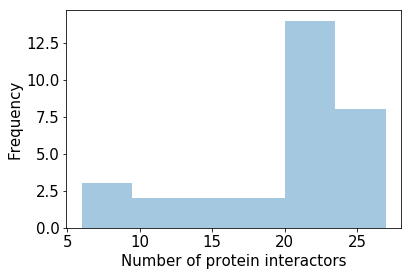

In [49]:
## Node degrees of the ACTN3 protein-protein interaction network.
ACTN3_degree_array = [21., 27., 26., 23., 20., 26., 27., 21., 21., 24., 17.,  6.,  7., 11., 16., 23., 14., 21., 20., 20., 21., 18., 21., 26., 27., 21.,27., 21., 12., 21.,  6.]

## Are these node degrees normally distributed?
sns.distplot(ACTN3_degree_array, kde = False)
plt.xlabel("Number of protein interactors")
plt.ylabel("Frequency");

## Hmm... maybe?

The Shapiro test statistic W=0.8771312236785889 and P-value=0.002030215924605727 for the ACTN3 PPIN


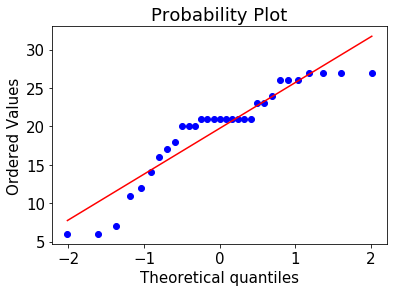

In [53]:
## Run the Shapiro-Wilk test on the above

ACTN3_results = stats.shapiro(ACTN3_degree_array)
print(f"The Shapiro test statistic W={ACTN3_results[0]} and P-value={ACTN3_results[1]} for the ACTN3 PPIN.")

# Show the quantile plot
stats.probplot(ACTN3_degree_array, sparams = (0,1), dist = "norm", plot = plt);

### There's more than just normality -- testing additional assumptions (slide 20)
------

Next we'll use a randomly selected portion of last lecture's CRISPR data (see [DepMap](https://depmap.org/portal/download/) and check if the two-sample t-test we ran last week was a good idea.

In [54]:
## Data from the DepMap CRISPR portal. Each data point describes the amount to with the knockout of SOX10 kills
# cancer cells, with more negative values indicating a greater killing capacity.

sox10_crispr_lung = [-0.60648904, -0.09495976, -0.57282039, -0.40766996, -0.27019758,
       -0.25366604, -0.45113227, -0.41343878, -0.49028263, -0.43903918,
       -0.34250056, -0.20517084, -0.1893333 , -0.40247561, -0.32716849,
       -0.25315907, -0.62722865, -0.33567284, -0.47922371, -0.23962372]

sox10_crispr_skin = [-1.93059717, -1.43425106, -1.56678867, -2.61922101, -1.3627694 ,
       -0.47425185, -1.2101267 , -1.20344136, -0.52612558, -0.34868256,
       -0.29555606, -1.25940655, -1.42941417, -1.45359515, -1.163126  ,
       -0.21464544, -1.33536708, -1.21071936, -1.344727  , -1.8762384 ]

# First check normality
print(stats.shapiro(sox10_crispr_lung))
print(stats.shapiro(sox10_crispr_skin))



(0.9767759442329407, 0.8860622644424438)
(0.9206569194793701, 0.10201295465230942)


In [ ]:
# Gotta check the standard deviation, too!
lung_var = np.std(sox10_crispr_lung, ddof = 1)
skin_var = np.std(sox10_crispr_skin, ddof = 1)

print(lung_var, skin_var)

In [57]:
# We shouldn't run a two-sample t-test! Run a Welch's test instead

# Two-sample (bad idea)
two_sample_results = stats.ttest_ind(sox10_crispr_lung, sox10_crispr_skin)
print(f"Two-sample results:{two_sample_results}")

# Welch's test (good idea)
welchs_results = stats.ttest_ind(sox10_crispr_lung,sox10_crispr_skin, equal_var=False)
print(f"Welch's test results:{welchs_results}")


Two-sample results:Ttest_indResult(statistic=6.092920579540422, pvalue=4.24495364789015e-07)
Welch's test results:Ttest_indResult(statistic=6.092920579540422, pvalue=4.603477529245655e-06)


------
## 2. Transform your non-normal data into something normal! (slide 25)
------


### Transformations in general
-------

[50 19 86 50]
[250  95 430 250]


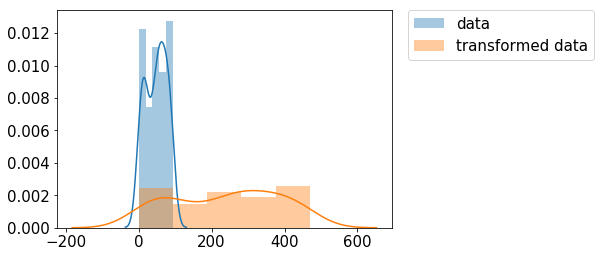

In [65]:
# First generate some random data. We'll just use random integers here
data = np.random.randint(100, size=100)
print(data[0:4])

transformed_data = 5*data
print(transformed_data[0:4])

# This transformation is not so helpful.
sns.distplot(data, label = "data");
sns.distplot(transformed_data, label = "transformed data");
lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0);

### Log-transform (slide 26)
------

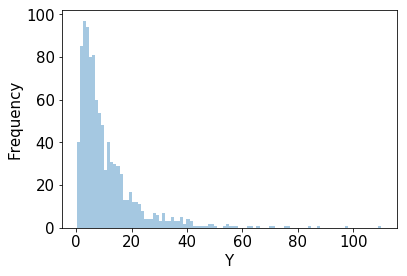

In [86]:
# Let's begin with some random data that we can then transform
data_1 = np.random.lognormal(mean = 2, sigma = 0.9, size = 1000)

# Draw a histogram of the data
sns.distplot(data_1, kde = False, bins = 100)
plt.xlabel("Y")
plt.ylabel("Frequency");

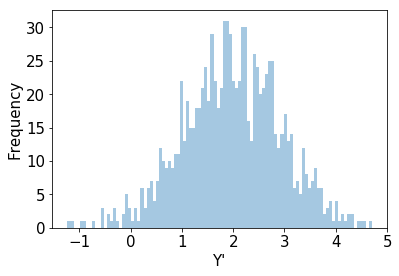

In [87]:
# Perform the log transform on the data witih np.log (slide 27)
# Note we use the prime ' to indicate transformed data

data_1_logged = np.log(data_1)
sns.distplot(data_1_logged, kde = False, bins = 100)
plt.xlabel("Y'")
plt.ylabel("Frequency");

### When is the log transform a good idea? (slide 29)

Text(0, 0.5, 'Relative Frequency')

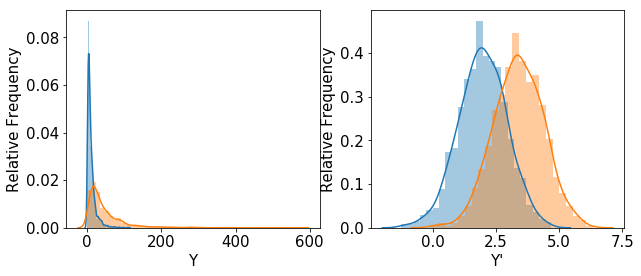

In [90]:
# Let's make another skewed sample and transform it.

data_2 = np.random.lognormal(mean = 3.4, sigma = 1, size = 1000)

# Plot both the distributions and their transformed distributions on the same axes.
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(data_1)
sns.distplot(data_2)
plt.xlabel("Y")
plt.ylabel("Relative Frequency")

# Plot the transformed data
plt.subplot(1,2,2)
sns.distplot(np.log(data_1))
sns.distplot(np.log(data_2))
plt.xlabel("Y'")
plt.ylabel("Relative Frequency")